# Deep Convolutional GAN

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [3]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [4]:
batch_size = 128

if not os.path.exists('./DCGAN'):
    os.makedirs('./DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
num_epochs = 20
learning_rate  = 1e-3
latent_vector_size = 128

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.deconv1 = nn.ConvTranspose2d( latent_vector_size, 64 * 8, 4, 1, 0, bias=False)
        self.norm1 = nn.BatchNorm2d(64 * 8)
        self.relu = nn.ReLU(True)
        self.deconv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(64 * 4)
        self.deconv3 = nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.norm3 = nn.BatchNorm2d(64 * 2)
        
        self.deconv4 = nn.ConvTranspose2d( 64 * 2, 3, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()

    def decode(self, z):

        z = self.relu(self.norm1(self.deconv1(z))) # b, 16, 5, 5
        z = self.relu(self.norm2(self.deconv2(z))) # b, 8, 15, 15
        z = self.relu(self.norm3(self.deconv3(z))) # b, 1, 28, 28
        z = self.tanh(self.deconv4(z))
        return z

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.norm3 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 1, 5, 2, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def discriminator(self, x):

        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.norm2(self.conv2(x)))
        x = self.lrelu(self.norm3(self.conv3(x)))
        x = self.conv4(x)
        
        return self.sigmoid(x)

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3677952
Generator(
  (deconv1): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)


Total number of parameters in Discriminator is: 665600
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace)
  (conv2): Conv2d(

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [12]:
export_folder = './DCGAN'
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
np.save('./DCGAN/train_losses_D.npy', train_losses_D)
np.save('./DCGAN/train_losses_G.npy', train_losses_G)
torch.save(model_G.state_dict(), './DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './DCGAN/DCGAN_model_D.pth')

[0/20][0/383] Loss_D: 1.4606 Loss_G: 10.2888 D(x): 0.5583 D(G(z)): 0.5339 / 0.0001
[0/20][1/383] Loss_D: 7.7821 Loss_G: 8.0874 D(x): 0.7293 D(G(z)): 0.9991 / 0.0004
[0/20][2/383] Loss_D: 3.4406 Loss_G: 12.5180 D(x): 0.5300 D(G(z)): 0.9043 / 0.0000
[0/20][3/383] Loss_D: 2.1083 Loss_G: 7.3006 D(x): 0.2573 D(G(z)): 0.0089 / 0.0009
[0/20][4/383] Loss_D: 7.7341 Loss_G: 9.3133 D(x): 0.7366 D(G(z)): 0.9993 / 0.0001
[0/20][5/383] Loss_D: 0.5130 Loss_G: 8.8268 D(x): 0.6667 D(G(z)): 0.0063 / 0.0002
[0/20][6/383] Loss_D: 0.4674 Loss_G: 6.8878 D(x): 0.7749 D(G(z)): 0.1244 / 0.0011
[0/20][7/383] Loss_D: 2.6541 Loss_G: 12.5215 D(x): 0.8640 D(G(z)): 0.9097 / 0.0000
[0/20][8/383] Loss_D: 0.6262 Loss_G: 12.7115 D(x): 0.6270 D(G(z)): 0.0000 / 0.0000
[0/20][9/383] Loss_D: 0.4460 Loss_G: 10.7046 D(x): 0.7148 D(G(z)): 0.0000 / 0.0000
[0/20][10/383] Loss_D: 0.1591 Loss_G: 5.4237 D(x): 0.8679 D(G(z)): 0.0063 / 0.0047
[0/20][11/383] Loss_D: 8.8552 Loss_G: 10.0075 D(x): 0.9278 D(G(z)): 0.9998 / 0.0000
[0/20][1

### Generator samples

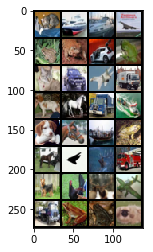

In [13]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

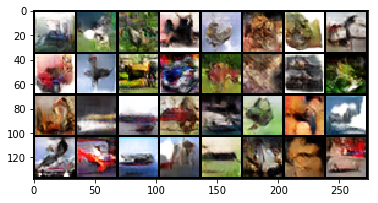

In [15]:
# load the model
model_G.load_state_dict(torch.load('./DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)